#  Intracranial Hemorrhage Detection

## Model 1: Base Line Model

#### Kristina Joos

---   

|                 	|                                                        	|
|:----------------:	|:-------------------------------------------------------:	|
| Model           	|                                      |
| Augmentation      |                                                        |
| Windowing         |                                                   	|
| Class Balancing 	| |
| Loss Function   	|Focal Loss                                      	|
| Regularization  	| 	                    |
| Epochs Run      	| 1                                                     	|
| Time Run (min)   	|    7:30                                          	|
|                 	|                                                        	|
| Test Sores      	| Loss:                                        	|
| Validation      	| Loss:                                        	|
| Leader Board    	| Score: 0.64879 Rank: 412                                	|



Some code taken from:
* https://www.kaggle.com/omission/eda-view-dicom-images-with-correct-windowing
* https://www.kaggle.com/c/rsna-intracranial-hemorrhage-detection/discussion/109649#latest-631701

Functions for Image Preprocessing (please see EDA notebook for details)
Steps:
- Read the dicom dataset of an raw dicom image
- Focus on a specific hounsfield window. This way we can get rid of information in the image we don't need. This could include signals from the CT-tube, towels or perhaps also some bones or further tissue we are not interested in.
- We need to make sure that all images have the same width and height. So far I haven't seen another shape than 512x512 but we don't know if this could change! In addition we need to make sure that the shape of the image is what is expected by our model.

In [11]:
import numpy as np
import pandas as pd
import pydicom
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import collections
from tqdm import tqdm_notebook as tqdm
from datetime import datetime

from math import ceil, floor, log
import cv2

import tensorflow as tf
#import tensorflow.keras
from tensorflow.keras import backend as K

import sys

# from keras_applications.resnet import ResNet50
from keras_applications.inception_v3 import InceptionV3




from skimage.transform import resize
from imgaug import augmenters as iaa
 
from sklearn.model_selection import train_test_split, StratifiedKFold, ShuffleSplit
from sklearn.metrics import confusion_matrix
import itertools

from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet_50
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg_16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Activation, concatenate, Dropout, MaxPooling2D, Conv2D, Flatten
from tensorflow.keras.initializers import glorot_normal, he_normal
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model, load_model, Sequential, load_model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.python.ops import array_ops

#from tensorflow.nn import sigmoid_cross_entropy_with_logits



In [12]:
tf.test.is_gpu_available()

True

In [13]:

tf.test.is_built_with_cuda()

True

In [14]:
test_images_dir = '../data/input/rsna-intracranial-hemorrhage-detection/stage_2_test/'
train_images_dir = '../data/input/rsna-intracranial-hemorrhage-detection/stage_2_train/'



In [15]:



def rescale_pixelarray(dataset):
    image = dataset.pixel_array
    rescaled_image = image * dataset.RescaleSlope + dataset.RescaleIntercept
    rescaled_image[rescaled_image < -1024] = -1024
    return rescaled_image

def set_manual_window(hu_image, min_value, max_value):
    hu_image[hu_image < min_value] = min_value
    hu_image[hu_image > max_value] = min_value #max_value
    return hu_image

class Preprocessor:    
    
    def __init__(self, path, augment=False):
        self.path = path
        self.nn_input_shape = (512, 512) 
        #self.hu_min_value = hu_min_value
        #self.hu_max_value = hu_max_value
        self.augment = augment
        
  #load the dicom dataset
    def load_dicom_dataset(self, filename):
        dataset = pydicom.dcmread(self.path + filename)
        return dataset
    
    #Rescale the pixelarray to HU units and set to window
    
    def get_hounsfield_window(self, dataset, min_value, max_value):
        
        hu_image = rescale_pixelarray(dataset)
        return hu_image

    def resize(self, image):
        image = resize(image, self.nn_input_shape)
        return image

    #augment our image
    def augment_img(self, image): 
        augment_img = iaa.Sequential([
            iaa.Crop(keep_size=True, percent=(0.01, 0.05), sample_independently=False),
            iaa.Affine(rotate=(-10, 10)),
            iaa.Fliplr(0.5)])
        image_aug = augment_img.augment_image(image)
        return image_aug
    
    def fill_channels(self, image):
        filled_image = np.stack((image,)*3, axis=-1)
        return filled_image
    
    def preprocess(self, identifier):
        filename = identifier +  ".dcm"
        dataset = self.load_dicom_dataset(filename)
        #windowed_image = self.get_hounsfield_window(dataset, self.hu_min_value, self.hu_max_value)
        #image = self.resize(windowed_image)
        array = dataset.pixel_array
        image = self.resize(array)
        if self.augment:
            image = self.augment_img(image)
        image = self.fill_channels(image)
        return image
    
    def normalize(self, image):
        return (image - self.hu_min_value)/(self.hu_max_value-self.hu_min_value) * 0.5


Custom dataloader 
As we have custom preprocessing we need to write a custom dataloader as well. For this purpose we will extend the keras Sequence class that allows us to use multiprocessing. Taking a look at the docs you can see that we have to:

implement the getitem method
and the len method
I like to pass unique image ids of train, dev or test data to the dataloader and load and preprocess images batchwise.

In [16]:
class DataLoader(Sequence):
    
    def __init__(self, dataframe,
                 preprocessor,
                 batch_size,
                 shuffle,
                 num_classes=6,
                 steps=None):
        
        self.preprocessor = preprocessor
        self.data_ids = dataframe.index.values
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.input_shape = (512, 512) #was 256,256
        #self.preprocess_fun = self.preprocessor.backbone["preprocess_fun"]
        self.num_classes = num_classes
        self.current_epoch=0
        
        self.steps=steps
        if self.steps is not None:
            self.steps = np.round(self.steps/3) * 3
            self.undersample()

    def undersample(self):
        part = np.int(self.steps/3 * self.batch_size)
        zero_ids = np.random.choice(self.dataframe.loc[self.dataframe["any"] == 0].index.values, size=2*part, replace=False)
        hot_ids = np.random.choice(self.dataframe.loc[self.dataframe["any"] == 1].index.values, size=1*part, replace=False)
        self.data_ids = list(set(zero_ids).union(hot_ids))
        np.random.shuffle(self.data_ids)

    # defines the number of steps per epoch
    def __len__(self):
        if self.steps is None:
            return np.int(np.ceil(len(self.data_ids) / np.float(self.batch_size)))
        else:
            return 3*np.int(self.steps/3) 
    
    # at the end of an epoch: 
    def on_epoch_end(self):
        # if steps is None and shuffle is true:
        if self.steps is None:
            self.data_ids = self.dataframe.index.values
            if self.shuffle:
                np.random.shuffle(self.data_ids)
        else:
            self.undersample()
        self.current_epoch += 1
    
    # should return a batch of images
    def __getitem__(self, item):
        # select the ids of the current batch
        current_ids = self.data_ids[item*self.batch_size:(item+1)*self.batch_size]
        X, y = self.__generate_batch(current_ids)
        return X, y
    
    
    
    # collect the preprocessed images and targets of one batch
    def __generate_batch(self, current_ids):
        X = np.empty((self.batch_size, *self.input_shape, 3))
        y = np.empty((self.batch_size, self.num_classes))
        for idx, ident in enumerate(current_ids):
            # Store sample
            image = self.preprocessor.preprocess(ident)
           # X[idx] = self.preprocessor.normalize(image)
            X[idx] = image
            # Store class
            y[idx] = self.__get_target(ident)
        return X, y
    
    # extract the targets of one image id:
    def __get_target(self, ident):
        targets = self.dataframe.loc[ident].values
        return targets

In [17]:
test_images_dir = '../data/input/rsna-intracranial-hemorrhage-detection/stage_2_test/'
train_images_dir = '../data/input/rsna-intracranial-hemorrhage-detection/stage_2_train/'



___META DATA:__

In [18]:
train_df = pd.read_csv('../data/input/rsna-intracranial-hemorrhage-detection/stage_2_train.csv')
train_df.head(1000)

,ID,Label
0,ID_12cadc6af_epidural,0
1,ID_12cadc6af_intraparenchymal,0
2,ID_12cadc6af_intraventricular,0
3,ID_12cadc6af_subarachnoid,0
4,ID_12cadc6af_subdural,0
5,ID_12cadc6af_any,0
6,ID_38fd7baa0_epidural,0
7,ID_38fd7baa0_intraparenchymal,0
8,ID_38fd7baa0_intraventricular,0
9,ID_38fd7baa0_subarachnoid,0


In [19]:
# Test submission as test 
test_df = pd.read_csv('../data/input/rsna-intracranial-hemorrhage-detection/stage_2_sample_submission.csv')
test_df.head(7)

,ID,Label
0,ID_0fbf6a978_epidural,0.5
1,ID_0fbf6a978_intraparenchymal,0.5
2,ID_0fbf6a978_intraventricular,0.5
3,ID_0fbf6a978_subarachnoid,0.5
4,ID_0fbf6a978_subdural,0.5
5,ID_0fbf6a978_any,0.5
6,ID_d62ec3412_epidural,0.5


In [20]:
label = train_df.Label.values
train_df = train_df.ID.str.rsplit("_", n=1, expand=True)
train_df.loc[:, "label"] = label
train_df = train_df.rename({0: "id", 1: "subtype"}, axis=1)
train_df.head()


,id,subtype,label
0,ID_12cadc6af,epidural,0
1,ID_12cadc6af,intraparenchymal,0
2,ID_12cadc6af,intraventricular,0
3,ID_12cadc6af,subarachnoid,0
4,ID_12cadc6af,subdural,0


In [21]:
label = test_df.Label.values
test_df = test_df.ID.str.rsplit("_", n=1, expand=True)
test_df.loc[:, "label"] = label
test_df = test_df.rename({0: "id", 1: "subtype"}, axis=1)
test_df.head()

,id,subtype,label
0,ID_0fbf6a978,epidural,0.5
1,ID_0fbf6a978,intraparenchymal,0.5
2,ID_0fbf6a978,intraventricular,0.5
3,ID_0fbf6a978,subarachnoid,0.5
4,ID_0fbf6a978,subdural,0.5


In [22]:
train_df.shape

(4516842, 3)

In [23]:
test_df.shape

(727392, 3)

In [24]:
train_df = pd.pivot_table(train_df, index="id", columns="subtype", values="label")
train_df.head()

subtype,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
id,,,,,,
ID_000012eaf,0,0,0,0,0,0
ID_000039fa0,0,0,0,0,0,0
ID_00005679d,0,0,0,0,0,0
ID_00008ce3c,0,0,0,0,0,0
ID_0000950d7,0,0,0,0,0,0


In [25]:
test_df = pd.pivot_table(test_df, index="id", columns="subtype", values="label")
test_df.head()

subtype,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
id,,,,,,
ID_000000e27,0.5,0.5,0.5,0.5,0.5,0.5
ID_000009146,0.5,0.5,0.5,0.5,0.5,0.5
ID_00007b8cb,0.5,0.5,0.5,0.5,0.5,0.5
ID_000134952,0.5,0.5,0.5,0.5,0.5,0.5
ID_000176f2a,0.5,0.5,0.5,0.5,0.5,0.5


In [26]:
train_df.shape


(752803, 6)

In [27]:
test_df.shape

(121232, 6)

_Train Val Split_

In [33]:
#Provides train/test indices to split data in train/test sets.

# This cross-validation object is a variation of KFold that returns
# stratified folds. The folds are made by preserving the percentage of
# samples for each class.

kfold = StratifiedKFold(n_splits=5, random_state=11, shuffle =True).split(X=np.arange(train_df.shape[0]), y=train_df["any"].values)

train_idx, val_idx = next(kfold)

train_data = train_df.iloc[train_idx]
val_data = train_df.iloc[val_idx]

#train_data, dev_data = train_test_split(traindf, test_size=0.1, stratify=traindf.values, random_state=split_seed)
print(train_data.shape)
print(val_data.shape)


(602242, 6)
(150561, 6)


In [34]:
train_data

subtype,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
id,,,,,,
ID_000039fa0,0,0,0,0,0,0
ID_00005679d,0,0,0,0,0,0
ID_00008ce3c,0,0,0,0,0,0
ID_0000950d7,0,0,0,0,0,0
ID_0000aee4b,0,0,0,0,0,0
ID_0000ca2f6,0,0,0,0,0,0
ID_0000f1657,0,0,0,0,0,0
ID_000178e76,0,0,0,0,0,0
ID_00019828f,0,0,0,0,0,0


In [36]:
val_data

subtype,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
id,,,,,,
ID_000012eaf,0,0,0,0,0,0
ID_0001dcc25,0,0,0,0,0,0
ID_000259ccf,0,0,0,0,0,0
ID_00027c277,0,0,0,0,0,0
ID_0002adc14,0,0,0,0,0,0
ID_00035b650,0,0,0,0,0,0
ID_000438d71,0,0,0,0,0,0
ID_000457398,0,0,0,0,0,0
ID_0004a5701,1,0,0,0,0,1


In [ ]:
val_data.to_csv('../data/output/submissions/val_data_model1_base.csv', index=False)

In [37]:
train_preprocessor = Preprocessor(path=train_images_dir,
                                  augment=False)

In [38]:
val_preprocessor = Preprocessor(path=train_images_dir,
                              
                                augment=False)


In [39]:
test_preprocessor = Preprocessor(path=test_images_dir,
                               
                                augment=False)

In [ ]:
val_test_preprocessor = Preprocessor(path=train_images_dir,
                               
                                augment=False)

In [40]:
train_dataloader = DataLoader(train_data,
                              train_preprocessor,
                              128,
                              shuffle=True,
                              steps=50)

val_dataloader = DataLoader(val_data, 
                            val_preprocessor,
                            128,
                            shuffle=True,
                            steps=50)

test_dataloader = DataLoader(test_df, 
                             test_preprocessor,
                             4,
                             shuffle=False)

In [ ]:
val_test_dataloader = DataLoader(val_data, 
                             val_test_preprocessor,
                             4,
                             shuffle=False)

In [41]:
train_dataloader.__len__()

51

In [42]:
len(train_dataloader.data_ids)/128

51.0

In [43]:
test_dataloader.__len__()

30308

In [44]:
len(test_dataloader.data_ids)/128

947.125

In [45]:
train_data.shape

(602242, 6)

In [46]:
len(train_dataloader.data_ids)

6528

In [47]:
train_data.loc[train_dataloader.data_ids]["any"].value_counts()


0    4352
1    2176
Name: any, dtype: int64

Loss Functions from here https://www.kaggle.com/akensert/inceptionv3-prev-resnet50-keras-baseline-model:

In [48]:
def focal_loss(prediction_tensor, target_tensor, weights=None, alpha=0.25, gamma=2):
    r"""Compute focal loss for predictions.
        Multi-labels Focal loss formula:
            FL = -alpha * (z-p)^gamma * log(p) -(1-alpha) * p^gamma * log(1-p)
                 ,which alpha = 0.25, gamma = 2, p = sigmoid(x), z = target_tensor.
    Args:
     prediction_tensor: A float tensor of shape [batch_size, num_anchors,
        num_classes] representing the predicted logits for each class
     target_tensor: A float tensor of shape [batch_size, num_anchors,
        num_classes] representing one-hot encoded classification targets
     weights: A float tensor of shape [batch_size, num_anchors]
     alpha: A scalar tensor for focal loss alpha hyper-parameter
     gamma: A scalar tensor for focal loss gamma hyper-parameter
    Returns:
        loss: A (scalar) tensor representing the value of the loss function
    """
    sigmoid_p = tf.nn.sigmoid(prediction_tensor)
    zeros = array_ops.zeros_like(sigmoid_p, dtype=sigmoid_p.dtype)
    
    # For poitive prediction, only need consider front part loss, back part is 0;
    # target_tensor > zeros <=> z=1, so poitive coefficient = z - p.
    pos_p_sub = array_ops.where(target_tensor > zeros, target_tensor - sigmoid_p, zeros)
    
    # For negative prediction, only need consider back part loss, front part is 0;
    # target_tensor > zeros <=> z=1, so negative coefficient = 0.
    neg_p_sub = array_ops.where(target_tensor > zeros, zeros, sigmoid_p)
    per_entry_cross_ent = - alpha * (pos_p_sub ** gamma) * K.log(tf.clip_by_value(sigmoid_p, 1e-8, 1.0)) \
                          - (1 - alpha) * (neg_p_sub ** gamma) * K.log(tf.clip_by_value(1.0 - sigmoid_p, 1e-8, 1.0))
    return tf.reduce_sum(per_entry_cross_ent)

In [51]:
cnn_model = Sequential()
cnn_model.add(Conv2D(filters = 16,
                    kernel_size = (3,3),
                    activation = 'relu',
                    input_shape = (512, 512, 3))) #was 256,256

cnn_model.add(MaxPooling2D(pool_size = (2,2)))

cnn_model.add(Conv2D(64, 
                    kernel_size = (3,3),
                    activation = 'relu'))

cnn_model.add(MaxPooling2D(pool_size = (2,2)))

cnn_model.add(Conv2D(filters = 32,
                     kernel_size = (3,3), 
                     activation = 'relu',
                     padding = 'same'))
              
cnn_model.add(MaxPooling2D(pool_size=(2,2)))
              
cnn_model.add(Conv2D(filters = 16,
                     kernel_size = (3,3), 
                     activation = 'relu',
                     padding = 'same'))
              
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

              
cnn_model.add(Flatten())

cnn_model.add(Dense(64, activation = 'relu'))

cnn_model.add(Dropout(0.5))

cnn_model.add(Dense(32, activation = 'relu'))

cnn_model.add(Dropout(0.5))

cnn_model.add(Dense(6, activation='sigmoid'))


cnn_model.compile(loss=focal_loss, optimizer='adam', metrics=['accuracy'])

In [52]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 510, 510, 16)      448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 255, 255, 16)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 253, 253, 64)      9280      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 126, 126, 64)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 126, 126, 32)      18464     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 63, 63, 16)       

In [53]:
# Set callback functions to early stop training and save the best model so far
my_callbacks = [ModelCheckpoint(filepath='../models/mymodels/cnn_model_base.h5', monitor='val_loss', save_best_only=True)]

In [ ]:
history = cnn_model.fit_generator(generator=train_dataloader,
                    validation_data=val_dataloader,
                    use_multiprocessing=True,
                    workers=12,epochs = 50,verbose = 1)

Epoch 1/50
51/51 [==============================] - 274s 5s/step - loss: 0.3868 - accuracy: 0.8621 - val_loss: 0.3598 - val_accuracy: 1.0000
Epoch 2/50
51/51 [==============================] - 260s 5s/step - loss: 0.3590 - accuracy: 0.9972 - val_loss: 0.3473 - val_accuracy: 1.0000
Epoch 3/50
51/51 [==============================] - 258s 5s/step - loss: 0.3555 - accuracy: 0.9997 - val_loss: 0.3449 - val_accuracy: 1.0000
Epoch 4/50
51/51 [==============================] - 255s 5s/step - loss: 0.3565 - accuracy: 1.0000 - val_loss: 0.3415 - val_accuracy: 1.0000
Epoch 5/50
51/51 [==============================] - 254s 5s/step - loss: 0.3529 - accuracy: 0.9983 - val_loss: 0.3475 - val_accuracy: 1.0000
Epoch 6/50
51/51 [==============================] - 256s 5s/step - loss: 0.3574 - accuracy: 1.0000 - val_loss: 0.3494 - val_accuracy: 1.0000
Epoch 7/50
51/51 [==============================] - 258s 5s/step - loss: 0.3469 - accuracy: 0.9998 - val_loss: 0.3433 - val_accuracy: 1.0000
Epoch 8/50
51

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize = (12,8))

plt.plot(train_loss, label = 'training_loss', color = 'b')
plt.plot(val_loss, label = 'val_loss', color = 'orange')

plt.title('Training and Validation Loss by Epochs')
plt.xlabel('Epochs')
plt.ylabel('weighted_log_loss');

In [ ]:
def make_df(meta_data_df, predictions):
    df = pd.DataFrame(predictions, columns=meta_data_df.columns, index=meta_data_df.index)
    df = df.stack().reset_index()
    df.loc[:, "ID"] = df.id.str.cat(df.subtype, sep="_")
    df = df.drop(["id", "subtype"], axis=1)
    df = df.rename({0: "Label"}, axis=1)
    return df

In [ ]:
val_predictions = cnn_model.predict_generator(val_test_dataloader,use_multiprocessing=True, workers = -1)

In [ ]:
test_predictions = cnn_model.predict_generator(test_dataloader,use_multiprocessing=True, workers = -1)



In [ ]:
test_predictions.shape

In [ ]:
test_df.shape

In [ ]:
test_predictions[:20]

In [ ]:
test_pred_df = make_df(test_df, test_predictions)

In [ ]:
test_pred_df = test_pred_df[['ID','Label']]

In [ ]:
test_pred_df.to_csv('../data/output/submissions/submission_base_model_1.csv', index=False)

In [ ]:
history.history.keys()

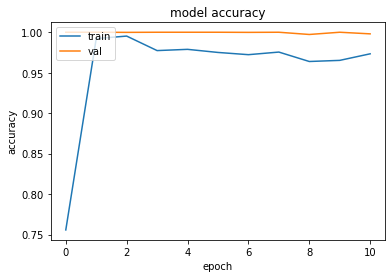

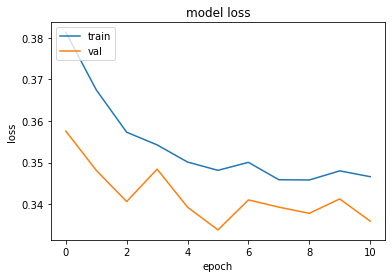

In [87]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [88]:

val_pred_dataloader = DataLoader(val_data, 
                            val_preprocessor,
                            9, shuffle = False)

In [89]:
val_predictions = cnn_model.predict_generator(val_pred_dataloader, use_multiprocessing=True, workers = -1)

KeyboardInterrupt: 

In [ ]:
val_pred_df = make_df(val_data, val_predictions)

In [ ]:
val_data.head()

In [235]:
val_pred_df.head()

,Label,ID
0,0.473071,ID_000012eaf_any
1,0.078606,ID_000012eaf_epidural
2,0.177197,ID_000012eaf_intraparenchymal
3,0.139710,ID_000012eaf_intraventricular
4,0.200750,ID_000012eaf_subarachnoid


In [236]:
val_labels = val_pred_df.Label.values
piv_val_pred_df = val_pred_df.ID.str.rsplit("_", n=1, expand=True)


In [237]:
piv_val_pred_df.loc[:, "label"] = val_labels



In [238]:
piv_val_pred_df = piv_val_pred_df.rename({0: "id", 1: "subtype"}, axis=1)
piv_val_pred_df = pd.pivot_table(piv_val_pred_df, index="id", columns="subtype", values="label")




In [ ]:
fig, ax = plt.subplots(2,1, figsize=(20,10))
sns.distplot(dev_proba_any[:,0], ax=ax[0], color="Purple")
sns.distplot(dev_proba_subtype[:,0], ax=ax[1])
sns.distplot(dev_proba_subtype[:,1], ax=ax[1])
sns.distplot(dev_proba_subtype[:,2], ax=ax[1])
sns.distplot(dev_proba_subtype[:,3], ax=ax[1])
sns.distplot(dev_proba_subtype[:,4], ax=ax[1])
ax[0].set_title("Predicted probability of hemorrhage occurence in dev batch")
ax[1].set_title("Predicted probability of hemorrhage subtypes in dev batch")

fig, ax = plt.subplots(2,1, figsize=(20,10))
sns.distplot(train_proba_any[:,0], ax=ax[0], color="Purple")
sns.distplot(train_proba_subtype[:,0], ax=ax[1])
sns.distplot(train_proba_subtype[:,1], ax=ax[1])
sns.distplot(train_proba_subtype[:,2], ax=ax[1])
sns.distplot(train_proba_subtype[:,3], ax=ax[1])
sns.distplot(train_proba_subtype[:,4], ax=ax[1])
ax[0].set_title("Predicted probability of hemorrhage occurence in train")
ax[1].set_title("Predicted probability of hemorrhage subtypes in train")


In [240]:
piv_val_pred_df['any'].max()

0.4871021

In [228]:
piv_val_pred_df['any'].loc[piv_val_pred_df['any']<0.5] = 0
piv_val_pred_df['any'].loc[piv_val_pred_df['any']>=0.5] = 1
#df.loc[df.A==0, 'B'] = df.loc[df.A==0, 'B'] / 2

In [231]:
piv_val_pred_df['any'].sum()

0.0

In [232]:
val_data['any'].sum()

21587

In [200]:
val_data.head(30)

subtype,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
id,,,,,,
ID_000012eaf,0,0,0,0,0,0
ID_000039fa0,0,0,0,0,0,0
ID_00005679d,0,0,0,0,0,0
ID_00008ce3c,0,0,0,0,0,0
ID_0000950d7,0,0,0,0,0,0
ID_0000aee4b,0,0,0,0,0,0
ID_0000ca2f6,0,0,0,0,0,0
ID_0000f1657,0,0,0,0,0,0
ID_000178e76,0,0,0,0,0,0


In [165]:
piv_val_pred_df.shape

(150561, 6)

In [167]:
piv_val_pred_df.columns

Index(['any', 'epidural', 'intraparenchymal', 'intraventricular',
       'subarachnoid', 'subdural'],
      dtype='object', name='subtype')

In [175]:
val_pred_arg = piv_val_pred_df.values.argmax(axis = 1)

In [176]:
val_arg = val_data.values.argmax(axis =1)

In [186]:
val_arg['any']

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices